In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict
import time
import copy
import math
import tqdm

from sklearn.model_selection import train_test_split
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
# ## Library to import code from other notebook
# !pip install nbimporter

## Importing all function from model
from Model import Retail_Recommendation

In [11]:
## Reading datasets
df = pd.read_parquet('../Data/data_with_features.parquet')
customer = pd.read_pickle('../Data/customer_history.pkl')
items = pd.read_pickle('../Data/item_summary.pkl')
baskets = pd.read_pickle('../Data/baskets.pkl')
itemsets = joblib.load('../Models/itemsets.joblib')
rules = pd.read_pickle('../Data/rules.pkl')
vectorizer = joblib.load('../Models/vectorizer.joblib')

# coefficients to train
params = {'alpha': 1.0, 'beta': 1.0, 'delta': 1.0, 'eta': 1.0, 'gamma': 1.0, 'epsilon': 1.0, 'd_effect': 0.5}

# Calculating parameters
Today = pd.Timestamp(df['Purchase Date'].max()) + pd.DateOffset(days=1)
Time_period = (df['Purchase Date'].max() - df['Purchase Date'].min()).days
d_effect = 0.5 # decay factor
EPS = 1e-9
DEFAULT_HALF_LIFE_DAYS = 7

In [12]:
Model = Retail_Recommendation(
    items_data = items,
    customer_data = customer,
    rules = rules,
    initial_weights = None,
    d_effect = 1,
    current_date = Today,
    Time_period = 150,
    filter_items = False,
    include_description = True,
    iteration_bar = False
)

### Part-5: Fine-tuning

We have our perfect recommendation function. <br>
Now, we will Fine-tune various constants and coefficients involved in the model.

But for Training this model, Firstly we need some form of data with which we can evaluate our model by categorizing loss function.

**Solution**: <br>
We can take each baskets and try to predict its last items. This convert it into a supervised classification problem.
If prediction is correct, then we can say that our model is performing well.

** Loss Function: ** Categorical cross entropy

#### 1) Baskets input and last item for recommendation:

In [13]:

## Keep only relevent features & baskets with some items -> Single item purchases are targeted and are therefore irrelevant
Carts = baskets[ baskets['Num products']>= 5].drop(columns=['Purchase Date', 'Purchase Time', 'InvoiceDate', 'Quantity', 'Amount', 'Total amount'])

# we assume all purchases will be made today -> recency bias will not be trained well.
Carts['X'] = Carts['StockCode'].apply(lambda x: x[:-1])
Carts['Y'] = Carts['StockCode'].apply(lambda x: x[-1])
print("Carts shape: ",Carts.shape)
Carts.sample(3)

Carts shape:  (19857, 8)


,Invoice,Customer ID,StockCode,Description,Price,Num products,X,Y
24230,559989,13319,"[23209, 23245, 23298, 47566, 22993, 22328, 223...","[lunch|bag|doiley|pattern, set|of|3|regency|ca...","[1.65, 4.95, 4.95, 4.95, 1.25, 2.95, 2.95, 1.2...",10,"[23209, 23245, 23298, 47566, 22993, 22328, 223...",20727
4474,503616,15215,"[48185, 48138, 48184, 22499, 22138, 21559, 217...","[door|mat|fairy|cake, door|mat|union|flag, doo...","[7.49, 7.49, 7.49, 5.95, 4.95, 2.55, 5.95, 3.9...",10,"[48185, 48138, 48184, 22499, 22138, 21559, 217...",21915
17051,539374,14769,"[82486, 82484, 82483, 71459, 84755, 22722, 227...","[wood|s/3|cabinet|ant|white|finish, wood|black...","[7.95, 6.45, 5.95, 0.85, 0.65, 3.95, 4.95, 4.9...",16,"[82486, 82484, 82483, 71459, 84755, 22722, 227...",22077


#### 2) Function to calculate loss for each parameters mapping:

In [14]:
def Categorical_Cross_Entropy(params, model, carts, top_n=10, batch_size=128):
    """
    Computes categorical cross-entropy for a single true item and predicted probabilities.

    params : list or np.array
        Model coefficients [alpha, beta, gamma, delta, epsilon, eta, d_effect]
    model : Retail_Recommendation_optimal_desc
    carts : pd.DataFrame
        Must have columns ['Customer ID', 'X', 'Y']
    top_n : int
        Number of top items to consider from recommendations
    batch_size : int
        Number of baskets to process in one batch  
        
    """
    total_loss = 0.0
    valid_count = 0
    
    model.weights = params # load current weights
    n_batches = int(np.ceil(len(carts) / batch_size))
    
    correct = 0
    for b in range(n_batches):
        batch = carts.iloc[b*batch_size:(b+1)*batch_size]

        X_batch = batch.drop(columns=['Y']) # basket

        # Generate recommendations (returns DataFrame)
        result = model.recommend(X_batch, top_n=top_n)  # choose sufficient top_n
        
        # Check if target item is in top-N
        for idx,(basket_idx, basket) in enumerate(batch.iterrows()):
            Y = basket['Y']
            rec_df = list(result.values())[idx]
            
            if Y in set(rec_df['StockCode']):
                prob = rec_df.loc[rec_df['StockCode'] == Y, 'Probability'].values[0]
                total_loss += -np.log(prob)
                correct += 1
            else:
                total_loss += -np.log(1e-6)
                # display(items.loc[items['StockCode'] == Y])

            valid_count += 1
        """ If the model didn’t predict the correct item, we assign it a very low probability penalty, meaning huge loss"""
    
    # print('Correct: ',correct," out of: ",valid_count)
    # represents -> average loss
    return (correct ,(total_loss / valid_count if valid_count > 0 else np.nan))
    
    ## for single item -> y_true = 1
## return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
loss = Categorical_Cross_Entropy(params, Model, Carts.sample(100))
print("Initial loss:", loss[1])

Initial loss: 13.324175564870082


#### 3) Function to train model:
We will run thorugh a sample of baskets to calculate loss. Then we will update the weights using numerical gradient descent.
For calculating numerical gradient of our loss function, we have two methods.

##### **1) Perturbation effect:**
Perturbation effect is a numerical method to estimate the gradient of a loss function by slightly changing (perturbing) each parameter and observing the change in loss. It works because the gradient represents the rate of change of the loss with respect to the parameter; by measuring how the loss changes with a small parameter shift, we approximate this rate. This is simple to implement but slower and less precise than analytical gradients.

In [15]:
import copy

def train_model(model, Carts, lr=0.05, n_iter=20, error=1e-4, sample_size=100,batch_size=32, top_n=10):
    """
    Train the Retail_Recommendation model by optimizing weights and d_effect
    using numerical gradient descent on categorical cross-entropy loss.
    
    Parameters
    ----------
    model : Retail_Recommendation
        Your initialized model
    carts : pd.DataFrame
        Must have columns ['Customer ID', 'X', 'Y']
    lr : float
        Learning rate
    n_iter : int
        Number of gradient descent iterations
    error : float
        Small perturbation for numerical gradient
    sample_size : int
        Numbers of baskets to consider for each iteration
    batch_size : int
        Number of baskets to process per batch for efficiency
    top_n : int
        How many items to consider for loss evaluation
    
    Returns
    -------
    best_params : dict
        Optimized model parameters
    history : list
        Loss per epoch
    """
    # Initialize parameters
    params = copy.deepcopy(model.weights) # completely new variables
    params['d_effect'] = model.d_effect
    
    history = []
    
    for epoch in range(1, n_iter+1):
        # ---- sample once per epoch for stable gradient estimation ----
        sample = Carts.sample(sample_size, random_state=epoch)
        
        # compute numerical gradient
        grads = {}
        for key in params.keys():
            orig = params[key]
            
            # perturn +error
            params[key] = orig + error
            model.history_cache.clear()
            model.recency_cache.clear()
            _, loss_plus = Categorical_Cross_Entropy(params, model, sample, top_n=top_n, batch_size=batch_size)
            # perturn -error
            params[key] = orig - error
            model.history_cache.clear()
            model.recency_cache.clear()
            _, loss_minus = Categorical_Cross_Entropy(params, model, sample, top_n=top_n, batch_size=batch_size)
            
            # compute central difference gradient
            grads[key] = (loss_plus - loss_minus) / (2 * error)
            # restore params
            params[key] = orig
        
        # update weights
        for key in params.keys():
            params[key] -= lr * grads[key]
            
        model.history_cache.clear()
        model.recency_cache.clear()
        # evaluate updated params once on the same sample to get loss and correct_count
        correct_total, epoch_loss = Categorical_Cross_Entropy(params, model, sample, top_n=top_n, batch_size=batch_size)
        
        # store history
        history.append( (epoch_loss, int(correct_total), copy.deepcopy(params)) )
        print(f"Epoch {epoch+1}/{n_iter} - Loss: {epoch_loss:.5f}, Correct: {correct_total}/{sample_size})")
  
    
    # Update model with final weights
    model.weights = {k: v for k, v in params.items() if k != 'd_effect'}
    model.d_effect = params['d_effect']
    
    return copy.deepcopy(params), history

##### **2) Analytical effect**:
Analytical gradient method computes the exact gradient of the loss function with respect to each model parameter directly from the probability formula. It works by differentiating the loss function algebraically, which provides precise gradient values for optimization. This approach is faster and more accurate than perturbation, especially for models with many parameters.

For each basket, the logit for item `i` is:
$$ log(Z_{u,i}) = b_i + \alpha*H_i + \beta*R_i + \delta*P_i + \eta*D_i + \gamma*T_i + \epsilon*log(1 + C_i) $$
$$ P_{u,i} = softmax( log(Z_{u,i}) )  $$

Then loss for single target item `y` is:
$$ loss = -log(P_{u,y}) $$

Using standard softmax cross-entropy derivatives:
$$ \frac{\partial L}{\partial w} = \sum_i (p_i - y_i).f^w_i $$

In [16]:
import numpy as np
import copy

def train_model_analytical(model, carts, top_n=25, batch_size=128, lr=0.05, n_epochs=20):
    """
    Analytical gradient descent training for Retail_Recommendation.
    Computes gradient from softmax probabilities and updates model weights.
    """
    # Prepare weights and initialize history
    params = copy.deepcopy(model.weights)
    params['d_effect'] = model.d_effect
    model.weights = params
    history = []

    for epoch in range(1, n_epochs + 1):
        total_loss, total_correct = 0.0, 0
        grads = {k: 0.0 for k in model.weights.keys()}

        n_batches = int(np.ceil(len(carts) / batch_size))

        for b in range(n_batches):
            batch = carts.iloc[b*batch_size : (b+1)*batch_size]
            X_batch = batch.drop(columns=['Y'])
            Y_batch = batch['Y'].values

            # Run recommendations
            result = model.recommend(X_batch, top_n=top_n)

            for idx, (basket_idx, row) in enumerate(batch.iterrows()):
                cid = row['Customer ID']
                basket_items = row['X']
                Y = Y_batch[idx]
                rec_df = list(result.values())[idx]

                # If true item not found — assign small probability
                if Y not in rec_df['StockCode'].values:
                    prob = 1e-6
                    total_loss += -np.log(prob)
                    continue

                # Probability for the true item
                prob = rec_df.loc[rec_df['StockCode'] == Y, 'Probability'].values[0]
                total_loss += -np.log(prob)
                total_correct += 1

                # ---- Gradient computation (analytical form) ----
                # Recompute logit components for this basket
                H = model.compute_history(cid)
                R = model.compute_rules_array(basket_items)
                T = model.compute_recency(cid)
                P = model.compute_price_array(None)
                D = model.compute_discount_array(None)

                # Feature vector (partial derivatives of logit w.r.t weights)
                features = {
                    'alpha': H,
                    'beta': R,
                    'gamma': T,
                    'delta': P,
                    'eta': D
                }

                # Predicted probabilities over all items (softmax)
                logit = (model.Bias
                         + params['alpha'] * H
                         + params['beta'] * R
                         + params['gamma'] * T
                         + params['delta'] * P
                         + params['eta'] * D)
                exps = np.exp(logit - logit.max())
                probs = exps / (exps.sum() + 1e-9)

                # Gradient for each weight
                for key in features.keys():
                    grads[key] += np.sum((probs - (model.all_items == Y)) * features[key])

        # Average gradients
        for key in grads.keys():
            grads[key] /= len(carts)

        # Gradient descent update
        for key in grads.keys():
            params[key] -= lr * grads[key]

        # Save model weights after epoch
        model.weights = {k: v for k, v in params.items() if k != 'd_effect'}
        model.d_effect = params['d_effect']

        avg_loss = total_loss / len(carts)
        history.append((avg_loss, total_correct, copy.deepcopy(params)))
        print(f"Epoch {epoch}/{n_epochs} - Loss: {avg_loss:.5f}, Correct: {total_correct}/{len(carts)}")

    return model


In [17]:
import numpy as np
import copy

def train_model_analytically(model, carts, top_n=25, batch_size=128, lr=0.1, n_epochs=20):
    def compute_features(baskets_df):
        n = len(baskets_df)
        H = np.zeros((n, model.n_items), dtype=np.float32)
        R = np.zeros((n, model.n_items), dtype=np.float32)
        T = np.zeros((n, model.n_items), dtype=np.float32)
        P = np.zeros((n, model.n_items), dtype=np.float32)
        D = np.zeros((n, model.n_items), dtype=np.float32)

        for idx, (_,row) in enumerate(baskets_df.iterrows()):
            cid = row['Customer ID']
            basket_items = row['X'] if isinstance(row['X'], (list, set)) else []
            
            H[idx] = model.compute_history(cid)
            T[idx] = model.compute_recency(cid)
            R[idx] = model.compute_rules_array(basket_items)
            P[idx] = model.compute_price_array(None)
            D[idx] = model.compute_discount_array(None)
        return {'H': H, 'R': R, 'T': T, 'P': P, 'D': D}

    # Initialize parameters
    params = copy.deepcopy(model.weights)
    params['d_effect'] = model.d_effect
    history = []

    for epoch in range(n_epochs):
        total_loss, correct_total, total_count = 0.0, 0, 0
        grads = {k: 0.0 for k in params.keys()}

        n_batches = int(np.ceil(len(carts) / batch_size))
        for b in range(n_batches):
            batch = carts.iloc[b*batch_size:(b+1)*batch_size]
            X_batch = batch.drop(columns=['Y'])
            Y_batch = batch['Y'].values

            feats = compute_features(X_batch)

            logit = (model.Bias
                     + params['alpha'] * feats['H']
                     + params['beta']  * feats['R']
                     + params['gamma'] * feats['T']
                     + params['delta'] * feats['P']
                     + params['eta']   * feats['D'])
            logit -= logit.max(axis=1, keepdims=True)
            exps = np.exp(logit)
            probs = exps / (exps.sum(axis=1, keepdims=True) + 1e-9)

            # Map Y to index in all_items
            Y_idx = np.array([np.where(model.all_items == y)[0][0] if y in model.all_items else -1 for y in Y_batch])
            valid_mask = (Y_idx != -1)
            batch_loss = -np.log(probs[np.arange(len(Y_batch))[valid_mask], Y_idx[valid_mask]] + 1e-9).mean()
            total_loss += batch_loss * len(Y_batch)

            one_hot = np.zeros_like(probs)
            one_hot[np.arange(len(Y_batch))[valid_mask], Y_idx[valid_mask]] = 1
            diff = (probs - one_hot) / len(Y_batch)

            grads['alpha'] += np.sum(diff * feats['H'])
            grads['beta']  += np.sum(diff * feats['R'])
            grads['gamma'] += np.sum(diff * feats['T'])
            grads['delta'] += np.sum(diff * feats['P'])
            grads['eta']   += np.sum(diff * feats['D'])

            # Accuracy
            top_preds = np.argmax(probs, axis=1)
            correct_total += np.sum((model.all_items[top_preds] == Y_batch) & valid_mask)
            total_count += np.sum(valid_mask)

        # Update weights
        for k in grads.keys():
            grads[k] /= total_count
            params[k] -= lr * grads[k]

        model.weights = {k: v for k, v in params.items() if k != 'd_effect'}
        model.d_effect = params['d_effect']

        epoch_loss = total_loss / total_count
        epoch_acc = correct_total / total_count
        history.append((epoch_loss, epoch_acc, copy.deepcopy(params)))

        print(f"Epoch {epoch+1}/{n_epochs} | Loss: {epoch_loss:.5f} | Accuracy: {epoch_acc:.3f}")
        print("Weights:", {k: round(v, 4) for k, v in params.items()})

    return model, history


#### Line-by-line explanation

1. Y_idx = np.array([ ... ])
- Maps each true label in Y_batch (which are item codes) to an integer index in `self.all_items`.
- If a true label is not found in `self.all_items`, it stores -1 (meaning invalid / unknown target).

2. valid_mask = Y_idx != -1
- A boolean array marking which rows have a valid (known) target. We will only compute loss/gradients for those rows.

3. if np.any(valid_mask):
- Only proceed if at least one target in the batch is valid.

4. batch_loss = -np.log(probs[np.arange(len(Y_batch))[valid_mask], Y_idx[valid_mask]] + 1e-9).mean()
- probs has shape `[batch_size, n_items]` and contains the predicted probability for each item for each basket.
- `np.arange(len(Y_batch))[valid_mask]` picks the row indices (samples) that have valid targets.
- `Y_idx[valid_mask]` picks the target class index for each of those valid samples.
- `probs[rows, cols]` extracts the predicted probability assigned to the true class for each valid sample.
- `-np.log(...)` computes negative log-likelihood for each valid sample.
- `.mean()` takes the mean across the valid samples in the batch → this is the average cross-entropy for that batch.

5. one_hot = np.zeros_like(probs)
- Creates an all-zeros array same shape as probs to build one-hot encodings of the true class per row.

6. one_hot[np.arange(len(Y_batch))[valid_mask], Y_idx[valid_mask]] = 1
- Places ones in one_hot at the (row, true_class) positions — only for valid rows.

7. diff = (probs - one_hot) / len(Y_batch)
- This is the (vectorized) gradient of the average cross-entropy loss with respect to the logits after softmax.
- For softmax + cross-entropy, ∂L/∂z = (probs − one_hot), where z are logits. Dividing by `len(Y_batch)` scales the gradient by batch size (makes the gradient the per-sample average when later summed).

##### Note: 
the code divides by `len(Y_batch)` (batch size), not by `valid_count`. This scales gradients consistently across batches, but if a lot of targets are invalid you might prefer dividing by `valid_count` — both are reasonable choices but they change effective step size.

In [18]:
# trained_result = train_model(Model, Carts, lr=0.1, n_iter=5, error=1e-4, sample_size=100, batch_size=32, top_n=25)
# final_weight, hist = trained_result
# print("History: ")
# for i, (loss, corrent, parameter) in enumerate(hist):
#     print(f"For {i} epoch, loss: {loss:.5f},  correct: {corrent}, parameter: {parameter}")

Out of these two unique methods, we will use analytical gradient descent.

In [19]:
# trained_model = train_model_analytically(Model, Carts.sample(1000), top_n=10, batch_size=128, lr=0.05, n_epochs=100)
# final_weight = trained_model[0].weights
# print("Final Weights: ")
# final_weight

In [20]:
# History = trained_model[1]
# print("History of model: ",)
# for iter in History:
#     print(iter[0])

In [21]:
# import pickle
# # Store best params
# with open('../Models/best_parameters.pkl', 'wb') as f:
#     pickle.dump(final_weight, f)

We will add these two function into our `Model.py` class

For training price array, we need some sort of pseudo budget parameter for each basket.

In [30]:
import math
import random

import pandas as pd
import numpy as np
from collections import defaultdict
import time

from sklearn.model_selection import train_test_split
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import copy

from itertools import combinations
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from Model import Retail_Recommendation

## Reading datasets
df = pd.read_parquet('../Data/data_with_features.parquet')
customer = pd.read_pickle('../Data/customer_history.pkl')
items = pd.read_pickle('../Data/item_summary.pkl')
baskets = pd.read_pickle('../Data/baskets.pkl')
itemsets = joblib.load('../Models/itemsets.joblib')
rules = pd.read_pickle('../Data/rules.pkl')
vectorizer = joblib.load('../Models/vectorizer.joblib')

# coefficients to train
params = {'alpha': 1.0, 'beta': 1.0, 'delta': 1.0, 'eta': 1.0, 'gamma': 0.1, 'epsilon': 2.0, 'd_effect': 0.5}

# Calculating parameters
Today = pd.Timestamp(df['Purchase Date'].max()) + pd.DateOffset(days=1)
Time_period = (df['Purchase Date'].max() - df['Purchase Date'].min()).days
d_effect = 0.5 # decay factor
EPS = 1e-9

Discount_dict = {} #{item: math.pow(np.random.default_rng().uniform(),(np.random.randint(1, 5))) for item in items.sample(100)['StockCode'].unique()}

# Training model from class methods
model = Retail_Recommendation(
    items_data = items,
    customer_data = customer,
    rules = rules,
    initial_weights = params,
    d_effect = 0.5,
    current_date = Today,
    Time_period = 100,
    filter_items = False,
    include_description = True,
    iteration_bar = False
)

Baskets = baskets[ baskets['Num products']>= 5].drop(columns=['Purchase Date', 'Purchase Time', 'InvoiceDate', 'Quantity', 'Amount', 'Total amount'])
# we assume all purchases will be made today -> recency bias will not be trained well.
Baskets['X'] = Baskets['StockCode'].apply(lambda x: x[:-1])
Baskets['Y'] = Baskets['StockCode'].apply(lambda x: x[-1])


Baskets['Total Cost'] = Baskets['Price'].apply(np.sum)
# randomly scale up.down total cost to simulate budget
# ±20% variation (uniform)
variation = np.random.uniform(0.9, 1.25, size=len(Baskets))
Baskets['pseudo_budget'] = Baskets['Total Cost'] * variation

# Splitting into training and testing data
train_baskets, test_baskets = train_test_split(Baskets, shuffle=True, test_size=0.2, random_state=42)

optimal_weights, history = model.train_model(train_baskets, lr=0.05, n_iter=100,
    error=1e-6, sample_size=5000, batch_size=128, top_n=100, budget_column='pseudo_budget',
    Learning_rate_decay=0.02, reg_lambda=0.05, clip_value=5, early_stopping=True, patience=5)
print("Final Weights: ")
optimal_weights

Epoch 1/100: 100%|██████████| 40/40 [00:03<00:00, 10.14it/s]


Epoch 1/100 | Loss: 7.521313 
params: {'alpha': np.float32(0.9951), 'beta': np.float32(1.2451), 'delta': np.float32(1.0001), 'eta': np.float32(0.9951), 'gamma': np.float32(0.0995), 'epsilon': np.float32(2.2451), 'd_effect': np.float32(0.4975)}
Correct predictions:  4748/5000 


Epoch 2/100: 100%|██████████| 40/40 [00:03<00:00, 10.15it/s]


Epoch 2/100 | Loss: 7.324176 
params: {'alpha': np.float32(0.9903), 'beta': np.float32(1.4855), 'delta': np.float32(1.0006), 'eta': np.float32(0.9903), 'gamma': np.float32(0.099), 'epsilon': np.float32(2.4855), 'd_effect': np.float32(0.4952)}
Correct predictions:  4789/5000 


Epoch 3/100: 100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Epoch 3/100 | Loss: 7.110485 
params: {'alpha': np.float32(0.9856), 'beta': np.float32(1.7213), 'delta': np.float32(1.002), 'eta': np.float32(0.9856), 'gamma': np.float32(0.0986), 'epsilon': np.float32(2.7213), 'd_effect': np.float32(0.4928)}
Correct predictions:  4814/5000 


Epoch 4/100: 100%|██████████| 40/40 [00:03<00:00, 10.62it/s]


Epoch 4/100 | Loss: 6.955095 
params: {'alpha': np.float32(0.9811), 'beta': np.float32(1.9528), 'delta': np.float32(1.0016), 'eta': np.float32(0.9811), 'gamma': np.float32(0.0981), 'epsilon': np.float32(2.9528), 'd_effect': np.float32(0.4905)}
Correct predictions:  4833/5000 


Epoch 5/100: 100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


Epoch 5/100 | Loss: 6.787812 
params: {'alpha': np.float32(0.9766), 'beta': np.float32(2.1801), 'delta': np.float32(1.0024), 'eta': np.float32(0.9766), 'gamma': np.float32(0.0977), 'epsilon': np.float32(3.1801), 'd_effect': np.float32(0.4883)}
Correct predictions:  4837/5000 


Epoch 6/100: 100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Epoch 6/100 | Loss: 6.640415 
params: {'alpha': np.float32(0.9723), 'beta': np.float32(2.4033), 'delta': np.float32(1.0032), 'eta': np.float32(0.9723), 'gamma': np.float32(0.0972), 'epsilon': np.float32(3.4033), 'd_effect': np.float32(0.4861)}
Correct predictions:  4836/5000 


Epoch 7/100: 100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Epoch 7/100 | Loss: 6.531035 
params: {'alpha': np.float32(0.968), 'beta': np.float32(2.6226), 'delta': np.float32(1.0032), 'eta': np.float32(0.968), 'gamma': np.float32(0.0968), 'epsilon': np.float32(3.6226), 'd_effect': np.float32(0.484)}
Correct predictions:  4817/5000 


Epoch 8/100: 100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


Epoch 8/100 | Loss: 6.392059 
params: {'alpha': np.float32(0.9638), 'beta': np.float32(2.8381), 'delta': np.float32(1.0023), 'eta': np.float32(0.9638), 'gamma': np.float32(0.0964), 'epsilon': np.float32(3.8381), 'd_effect': np.float32(0.4819)}
Correct predictions:  4820/5000 


Epoch 9/100: 100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


Epoch 9/100 | Loss: 6.261491 
params: {'alpha': np.float32(0.9597), 'beta': np.float32(3.0156), 'delta': np.float32(1.0015), 'eta': np.float32(0.9597), 'gamma': np.float32(0.096), 'epsilon': np.float32(4.05), 'd_effect': np.float32(0.4799)}
Correct predictions:  4843/5000 


Epoch 10/100: 100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch 10/100 | Loss: 6.118893 
params: {'alpha': np.float32(0.9557), 'beta': np.float32(3.1794), 'delta': np.float32(0.9996), 'eta': np.float32(0.9557), 'gamma': np.float32(0.0956), 'epsilon': np.float32(4.2583), 'd_effect': np.float32(0.4779)}
Correct predictions:  4843/5000 


Epoch 11/100: 100%|██████████| 40/40 [00:03<00:00, 10.49it/s]


Epoch 11/100 | Loss: 6.043582 
params: {'alpha': np.float32(0.9518), 'beta': np.float32(3.3032), 'delta': np.float32(0.9978), 'eta': np.float32(0.9518), 'gamma': np.float32(0.0952), 'epsilon': np.float32(4.4632), 'd_effect': np.float32(0.4759)}
Correct predictions:  4823/5000 


Epoch 12/100: 100%|██████████| 40/40 [00:03<00:00, 10.32it/s]


Epoch 12/100 | Loss: 5.912457 
params: {'alpha': np.float32(0.948), 'beta': np.float32(3.3808), 'delta': np.float32(0.9968), 'eta': np.float32(0.948), 'gamma': np.float32(0.0948), 'epsilon': np.float32(4.6648), 'd_effect': np.float32(0.474)}
Correct predictions:  4864/5000 


Epoch 13/100: 100%|██████████| 40/40 [00:04<00:00,  9.97it/s]


Epoch 13/100 | Loss: 5.894025 
params: {'alpha': np.float32(0.9442), 'beta': np.float32(3.4222), 'delta': np.float32(0.9949), 'eta': np.float32(0.9442), 'gamma': np.float32(0.0944), 'epsilon': np.float32(4.8633), 'd_effect': np.float32(0.4721)}
Correct predictions:  4820/5000 


Epoch 14/100: 100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


Epoch 14/100 | Loss: 5.768508 
params: {'alpha': np.float32(0.9405), 'beta': np.float32(3.4355), 'delta': np.float32(0.9924), 'eta': np.float32(0.9405), 'gamma': np.float32(0.0941), 'epsilon': np.float32(5.0586), 'd_effect': np.float32(0.4703)}
Correct predictions:  4852/5000 


Epoch 15/100: 100%|██████████| 40/40 [00:04<00:00,  8.70it/s]


Epoch 15/100 | Loss: 5.719904 
params: {'alpha': np.float32(0.9369), 'beta': np.float32(3.4328), 'delta': np.float32(0.9896), 'eta': np.float32(0.9369), 'gamma': np.float32(0.0937), 'epsilon': np.float32(5.2509), 'd_effect': np.float32(0.4685)}
Correct predictions:  4845/5000 


Epoch 16/100: 100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


Epoch 16/100 | Loss: 5.658514 
params: {'alpha': np.float32(0.9334), 'beta': np.float32(3.4255), 'delta': np.float32(0.9881), 'eta': np.float32(0.9334), 'gamma': np.float32(0.0933), 'epsilon': np.float32(5.4403), 'd_effect': np.float32(0.4667)}
Correct predictions:  4837/5000 


Epoch 17/100: 100%|██████████| 40/40 [00:04<00:00,  9.84it/s]


Epoch 17/100 | Loss: 5.570711 
params: {'alpha': np.float32(0.9299), 'beta': np.float32(3.3864), 'delta': np.float32(0.9856), 'eta': np.float32(0.9299), 'gamma': np.float32(0.093), 'epsilon': np.float32(5.6268), 'd_effect': np.float32(0.4649)}
Correct predictions:  4846/5000 


Epoch 18/100: 100%|██████████| 40/40 [00:04<00:00,  9.57it/s]


Epoch 18/100 | Loss: 5.518690 
params: {'alpha': np.float32(0.9265), 'beta': np.float32(3.3286), 'delta': np.float32(0.9832), 'eta': np.float32(0.9265), 'gamma': np.float32(0.0926), 'epsilon': np.float32(5.8107), 'd_effect': np.float32(0.4632)}
Correct predictions:  4856/5000 


Epoch 19/100: 100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 19/100 | Loss: 5.428168 
params: {'alpha': np.float32(0.9231), 'beta': np.float32(3.273), 'delta': np.float32(0.9806), 'eta': np.float32(0.9231), 'gamma': np.float32(0.0923), 'epsilon': np.float32(5.9918), 'd_effect': np.float32(0.4616)}
Correct predictions:  4869/5000 


Epoch 20/100: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Epoch 20/100 | Loss: 5.372914 
params: {'alpha': np.float32(0.9198), 'beta': np.float32(3.2102), 'delta': np.float32(0.9778), 'eta': np.float32(0.9198), 'gamma': np.float32(0.092), 'epsilon': np.float32(6.1704), 'd_effect': np.float32(0.4599)}
Correct predictions:  4850/5000 


Epoch 21/100: 100%|██████████| 40/40 [00:03<00:00, 10.48it/s]


Epoch 21/100 | Loss: 5.308037 
params: {'alpha': np.float32(0.9166), 'beta': np.float32(3.1312), 'delta': np.float32(0.9754), 'eta': np.float32(0.9166), 'gamma': np.float32(0.0917), 'epsilon': np.float32(6.3464), 'd_effect': np.float32(0.4583)}
Correct predictions:  4862/5000 


Epoch 22/100: 100%|██████████| 40/40 [00:03<00:00, 10.02it/s]


Epoch 22/100 | Loss: 5.267775 
params: {'alpha': np.float32(0.9134), 'beta': np.float32(3.0559), 'delta': np.float32(0.9736), 'eta': np.float32(0.9134), 'gamma': np.float32(0.0913), 'epsilon': np.float32(6.5201), 'd_effect': np.float32(0.4567)}
Correct predictions:  4860/5000 


Epoch 23/100: 100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch 23/100 | Loss: 5.216151 
params: {'alpha': np.float32(0.9103), 'beta': np.float32(2.9773), 'delta': np.float32(0.9712), 'eta': np.float32(0.9103), 'gamma': np.float32(0.091), 'epsilon': np.float32(6.6913), 'd_effect': np.float32(0.4551)}
Correct predictions:  4865/5000 


Epoch 24/100: 100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


Epoch 24/100 | Loss: 5.182287 
params: {'alpha': np.float32(0.9072), 'beta': np.float32(2.9017), 'delta': np.float32(0.9694), 'eta': np.float32(0.9072), 'gamma': np.float32(0.0907), 'epsilon': np.float32(6.8602), 'd_effect': np.float32(0.4536)}
Correct predictions:  4847/5000 


Epoch 25/100: 100%|██████████| 40/40 [00:03<00:00, 11.18it/s]


Epoch 25/100 | Loss: 5.124405 
params: {'alpha': np.float32(0.9042), 'beta': np.float32(2.8207), 'delta': np.float32(0.9667), 'eta': np.float32(0.9042), 'gamma': np.float32(0.0904), 'epsilon': np.float32(7.0269), 'd_effect': np.float32(0.4521)}
Correct predictions:  4856/5000 


Epoch 26/100: 100%|██████████| 40/40 [00:03<00:00, 10.65it/s]


Epoch 26/100 | Loss: 5.088299 
params: {'alpha': np.float32(0.9012), 'beta': np.float32(2.7409), 'delta': np.float32(0.9646), 'eta': np.float32(0.9012), 'gamma': np.float32(0.0901), 'epsilon': np.float32(7.1914), 'd_effect': np.float32(0.4506)}
Correct predictions:  4845/5000 


Epoch 27/100: 100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Epoch 27/100 | Loss: 5.047820 
params: {'alpha': np.float32(0.8983), 'beta': np.float32(2.6682), 'delta': np.float32(0.9624), 'eta': np.float32(0.8983), 'gamma': np.float32(0.0898), 'epsilon': np.float32(7.3537), 'd_effect': np.float32(0.4491)}
Correct predictions:  4841/5000 


Epoch 28/100: 100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


Epoch 28/100 | Loss: 4.967681 
params: {'alpha': np.float32(0.8954), 'beta': np.float32(2.5955), 'delta': np.float32(0.9607), 'eta': np.float32(0.8954), 'gamma': np.float32(0.0895), 'epsilon': np.float32(7.5139), 'd_effect': np.float32(0.4477)}
Correct predictions:  4856/5000 


Epoch 29/100: 100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 29/100 | Loss: 4.949382 
params: {'alpha': np.float32(0.8926), 'beta': np.float32(2.5108), 'delta': np.float32(0.9589), 'eta': np.float32(0.8926), 'gamma': np.float32(0.0893), 'epsilon': np.float32(7.6722), 'd_effect': np.float32(0.4463)}
Correct predictions:  4850/5000 


Epoch 30/100: 100%|██████████| 40/40 [00:03<00:00, 10.47it/s]


Epoch 30/100 | Loss: 4.901289 
params: {'alpha': np.float32(0.8898), 'beta': np.float32(2.4222), 'delta': np.float32(0.9569), 'eta': np.float32(0.8898), 'gamma': np.float32(0.089), 'epsilon': np.float32(7.8284), 'd_effect': np.float32(0.4449)}
Correct predictions:  4863/5000 


Epoch 31/100: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 31/100 | Loss: 4.828310 
params: {'alpha': np.float32(0.887), 'beta': np.float32(2.3524), 'delta': np.float32(0.9547), 'eta': np.float32(0.887), 'gamma': np.float32(0.0887), 'epsilon': np.float32(7.9827), 'd_effect': np.float32(0.4435)}
Correct predictions:  4853/5000 


Epoch 32/100: 100%|██████████| 40/40 [00:03<00:00, 10.49it/s]


Epoch 32/100 | Loss: 4.787457 
params: {'alpha': np.float32(0.8843), 'beta': np.float32(2.2784), 'delta': np.float32(0.9532), 'eta': np.float32(0.8843), 'gamma': np.float32(0.0884), 'epsilon': np.float32(8.1352), 'd_effect': np.float32(0.4422)}
Correct predictions:  4864/5000 


Epoch 33/100: 100%|██████████| 40/40 [00:03<00:00, 11.12it/s]


Epoch 33/100 | Loss: 4.801465 
params: {'alpha': np.float32(0.8816), 'beta': np.float32(2.1948), 'delta': np.float32(0.9516), 'eta': np.float32(0.8816), 'gamma': np.float32(0.0882), 'epsilon': np.float32(8.2858), 'd_effect': np.float32(0.4408)}
Correct predictions:  4855/5000 


Epoch 34/100: 100%|██████████| 40/40 [00:03<00:00, 10.62it/s]


Epoch 34/100 | Loss: 4.751804 
params: {'alpha': np.float32(0.879), 'beta': np.float32(2.1202), 'delta': np.float32(0.9501), 'eta': np.float32(0.879), 'gamma': np.float32(0.0879), 'epsilon': np.float32(8.4346), 'd_effect': np.float32(0.4395)}
Correct predictions:  4850/5000 


Epoch 35/100: 100%|██████████| 40/40 [00:03<00:00, 11.14it/s]


Epoch 35/100 | Loss: 4.705212 
params: {'alpha': np.float32(0.8764), 'beta': np.float32(2.0355), 'delta': np.float32(0.9481), 'eta': np.float32(0.8764), 'gamma': np.float32(0.0876), 'epsilon': np.float32(8.5817), 'd_effect': np.float32(0.4382)}
Correct predictions:  4866/5000 


Epoch 36/100: 100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Epoch 36/100 | Loss: 4.652225 
params: {'alpha': np.float32(0.8739), 'beta': np.float32(1.9728), 'delta': np.float32(0.9468), 'eta': np.float32(0.8739), 'gamma': np.float32(0.0874), 'epsilon': np.float32(8.727), 'd_effect': np.float32(0.4369)}
Correct predictions:  4853/5000 


Epoch 37/100: 100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 37/100 | Loss: 4.645550 
params: {'alpha': np.float32(0.8714), 'beta': np.float32(1.8971), 'delta': np.float32(0.9458), 'eta': np.float32(0.8714), 'gamma': np.float32(0.0871), 'epsilon': np.float32(8.8707), 'd_effect': np.float32(0.4357)}
Correct predictions:  4860/5000 


Epoch 38/100: 100%|██████████| 40/40 [00:03<00:00, 10.48it/s]


Epoch 38/100 | Loss: 4.617890 
params: {'alpha': np.float32(0.8689), 'beta': np.float32(1.8095), 'delta': np.float32(0.9441), 'eta': np.float32(0.8689), 'gamma': np.float32(0.0869), 'epsilon': np.float32(9.0127), 'd_effect': np.float32(0.4345)}
Correct predictions:  4851/5000 


Epoch 39/100: 100%|██████████| 40/40 [00:04<00:00,  9.87it/s]


Epoch 39/100 | Loss: 4.524046 
params: {'alpha': np.float32(0.8665), 'beta': np.float32(1.7394), 'delta': np.float32(0.9422), 'eta': np.float32(0.8665), 'gamma': np.float32(0.0866), 'epsilon': np.float32(9.1532), 'd_effect': np.float32(0.4332)}
Correct predictions:  4871/5000 


Epoch 40/100: 100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


Epoch 40/100 | Loss: 4.553234 
params: {'alpha': np.float32(0.8641), 'beta': np.float32(1.6603), 'delta': np.float32(0.9409), 'eta': np.float32(0.8641), 'gamma': np.float32(0.0864), 'epsilon': np.float32(9.2921), 'd_effect': np.float32(0.432)}
Correct predictions:  4855/5000 


Epoch 41/100: 100%|██████████| 40/40 [00:04<00:00,  9.60it/s]


Epoch 41/100 | Loss: 4.538695 
params: {'alpha': np.float32(0.8617), 'beta': np.float32(1.5994), 'delta': np.float32(0.9396), 'eta': np.float32(0.8617), 'gamma': np.float32(0.0862), 'epsilon': np.float32(9.4294), 'd_effect': np.float32(0.4308)}
Correct predictions:  4843/5000 


Epoch 42/100: 100%|██████████| 40/40 [00:03<00:00, 10.25it/s]


Epoch 42/100 | Loss: 4.464477 
params: {'alpha': np.float32(0.8593), 'beta': np.float32(1.5229), 'delta': np.float32(0.9388), 'eta': np.float32(0.8593), 'gamma': np.float32(0.0859), 'epsilon': np.float32(9.5653), 'd_effect': np.float32(0.4297)}
Correct predictions:  4869/5000 


Epoch 43/100: 100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


Epoch 43/100 | Loss: 4.444019 
params: {'alpha': np.float32(0.857), 'beta': np.float32(1.4519), 'delta': np.float32(0.9373), 'eta': np.float32(0.857), 'gamma': np.float32(0.0857), 'epsilon': np.float32(9.6997), 'd_effect': np.float32(0.4285)}
Correct predictions:  4850/5000 


Epoch 44/100: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 44/100 | Loss: 4.454308 
params: {'alpha': np.float32(0.8548), 'beta': np.float32(1.3825), 'delta': np.float32(0.9363), 'eta': np.float32(0.8548), 'gamma': np.float32(0.0855), 'epsilon': np.float32(9.8327), 'd_effect': np.float32(0.4274)}
Correct predictions:  4856/5000 


Epoch 45/100: 100%|██████████| 40/40 [00:03<00:00, 10.26it/s]


Epoch 45/100 | Loss: 4.396729 
params: {'alpha': np.float32(0.8525), 'beta': np.float32(1.3318), 'delta': np.float32(0.9354), 'eta': np.float32(0.8525), 'gamma': np.float32(0.0853), 'epsilon': np.float32(9.9643), 'd_effect': np.float32(0.4263)}
Correct predictions:  4849/5000 


Epoch 46/100: 100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Epoch 46/100 | Loss: 4.380966 
params: {'alpha': np.float32(0.8503), 'beta': np.float32(1.2681), 'delta': np.float32(0.9345), 'eta': np.float32(0.8503), 'gamma': np.float32(0.085), 'epsilon': np.float32(10.0875), 'd_effect': np.float32(0.4251)}
Correct predictions:  4853/5000 


Epoch 47/100: 100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch 47/100 | Loss: 4.390823 
params: {'alpha': np.float32(0.8481), 'beta': np.float32(1.2026), 'delta': np.float32(0.9333), 'eta': np.float32(0.8481), 'gamma': np.float32(0.0848), 'epsilon': np.float32(10.1954), 'd_effect': np.float32(0.424)}
Correct predictions:  4855/5000 


Epoch 48/100: 100%|██████████| 40/40 [00:04<00:00,  9.74it/s]


Epoch 48/100 | Loss: 4.362090 
params: {'alpha': np.float32(0.8459), 'beta': np.float32(1.1495), 'delta': np.float32(0.9325), 'eta': np.float32(0.8459), 'gamma': np.float32(0.0846), 'epsilon': np.float32(10.3013), 'd_effect': np.float32(0.423)}
Correct predictions:  4841/5000 


Epoch 49/100: 100%|██████████| 40/40 [00:04<00:00,  9.77it/s]


Epoch 49/100 | Loss: 4.355523 
params: {'alpha': np.float32(0.8438), 'beta': np.float32(1.0949), 'delta': np.float32(0.9315), 'eta': np.float32(0.8438), 'gamma': np.float32(0.0844), 'epsilon': np.float32(10.3993), 'd_effect': np.float32(0.4219)}
Correct predictions:  4846/5000 


Epoch 50/100: 100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch 50/100 | Loss: 4.296359 
params: {'alpha': np.float32(0.8417), 'beta': np.float32(1.0448), 'delta': np.float32(0.9305), 'eta': np.float32(0.8417), 'gamma': np.float32(0.0842), 'epsilon': np.float32(10.4932), 'd_effect': np.float32(0.4208)}
Correct predictions:  4877/5000 


Epoch 51/100: 100%|██████████| 40/40 [00:04<00:00,  9.23it/s]


Epoch 51/100 | Loss: 4.307471 
params: {'alpha': np.float32(0.8396), 'beta': np.float32(0.9986), 'delta': np.float32(0.9308), 'eta': np.float32(0.8396), 'gamma': np.float32(0.084), 'epsilon': np.float32(10.5825), 'd_effect': np.float32(0.4198)}
Correct predictions:  4848/5000 


Epoch 52/100: 100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 52/100 | Loss: 4.222018 
params: {'alpha': np.float32(0.8375), 'beta': np.float32(0.9567), 'delta': np.float32(0.93), 'eta': np.float32(0.8375), 'gamma': np.float32(0.0838), 'epsilon': np.float32(10.6714), 'd_effect': np.float32(0.4188)}
Correct predictions:  4869/5000 


Epoch 53/100: 100%|██████████| 40/40 [00:04<00:00,  9.23it/s]


Epoch 53/100 | Loss: 4.278197 
params: {'alpha': np.float32(0.8355), 'beta': np.float32(0.9032), 'delta': np.float32(0.9299), 'eta': np.float32(0.8355), 'gamma': np.float32(0.0836), 'epsilon': np.float32(10.7475), 'd_effect': np.float32(0.4178)}
Correct predictions:  4859/5000 


Epoch 54/100: 100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


Epoch 54/100 | Loss: 4.263962 
params: {'alpha': np.float32(0.8335), 'beta': np.float32(0.8596), 'delta': np.float32(0.93), 'eta': np.float32(0.8335), 'gamma': np.float32(0.0834), 'epsilon': np.float32(10.8246), 'd_effect': np.float32(0.4168)}
Correct predictions:  4859/5000 


Epoch 55/100: 100%|██████████| 40/40 [00:04<00:00, 10.00it/s]


Epoch 55/100 | Loss: 4.265720 
params: {'alpha': np.float32(0.8315), 'beta': np.float32(0.8094), 'delta': np.float32(0.9298), 'eta': np.float32(0.8315), 'gamma': np.float32(0.0832), 'epsilon': np.float32(10.8963), 'd_effect': np.float32(0.4158)}
Correct predictions:  4845/5000 


Epoch 56/100: 100%|██████████| 40/40 [00:04<00:00,  9.45it/s]


Epoch 56/100 | Loss: 4.309920 
params: {'alpha': np.float32(0.8296), 'beta': np.float32(0.768), 'delta': np.float32(0.9288), 'eta': np.float32(0.8296), 'gamma': np.float32(0.083), 'epsilon': np.float32(10.9629), 'd_effect': np.float32(0.4148)}
Correct predictions:  4839/5000 


Epoch 57/100: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s]

Epoch 57/100 | Loss: 4.253195 
params: {'alpha': np.float32(0.8276), 'beta': np.float32(0.7237), 'delta': np.float32(0.9292), 'eta': np.float32(0.8276), 'gamma': np.float32(0.0828), 'epsilon': np.float32(11.0276), 'd_effect': np.float32(0.4138)}
Correct predictions:  4856/5000 
Early stopping triggered at epoch 57. Restoring best parameters from epoch 52.
Final Weights: 


{'alpha': np.float32(0.84168327),
 'beta': np.float32(1.0448098),
 'delta': np.float32(0.93048894),
 'eta': np.float32(0.84168327),
 'gamma': np.float32(0.08416832),
 'epsilon': np.float32(10.493217),
 'd_effect': np.float32(0.42084163)}

In [31]:
print("Best Parameters: ", model.best_params)
print("Best accuracy: ", model.best_result,'/', 5000)

print("Total number of items: ", len(items))

Best Parameters:  {'alpha': np.float32(0.84168327), 'beta': np.float32(1.0448098), 'delta': np.float32(0.93048894), 'eta': np.float32(0.84168327), 'gamma': np.float32(0.08416832), 'epsilon': np.float32(10.493217), 'd_effect': np.float32(0.42084163)}
Best accuracy:  4877 / 5000
Total number of items:  4888


In [ ]:
# import pickle
# # Store best params
# with open('../Models/best_parameters.pkl', 'wb') as f:
#     pickle.dump(optimal_weights, f)

In [ ]:
# import pickle

# par = pd.read_pickle('../Models/best_parameters.pkl')
# par

{'alpha': np.float32(0.84168327),
 'beta': np.float32(1.044839),
 'delta': np.float32(0.9319789),
 'eta': np.float32(0.84168327),
 'gamma': np.float32(0.08416832),
 'epsilon': np.float32(10.493215),
 'd_effect': np.float32(0.42084163)}

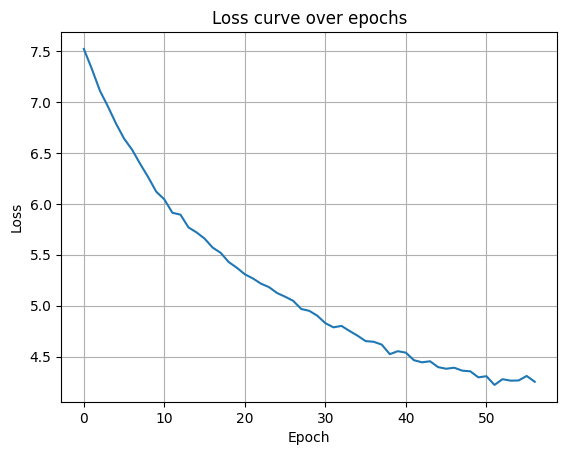

In [32]:
import matplotlib.pyplot as plt

plt.plot([h[0] for h in history])

plt.title("Loss curve over epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid()
plt.show()

Our model is overfitting which is causing our performance to not improve after a certain point.
So, we will implement some regularization to prevent overfitting.

1) L2 regularization factor
2) Gradient clipping for stable training
3) Learning rate decay factor
4) Early stopping based on validation set

In [ ]:
def train_model(Model_rec, Carts, lr=0.05, n_iter=20, error=1e-6, sample_size=None,
            batch_size=32, top_n=50, budget_column=None, verbose=True,
            Learning_rate_decay=0, reg_lambda=0.0, clip_value=None, early_stopping=False, patience=5):
        """
        Args:
            - Carts: DataFrame with baskets data
            - lr: learning rate
            - n_iter: number of gradient descent iterations
            - error: Minimum error threshold for each item
            - sample_size: size of sample for training our model
            
            - batch_size: size of batches for prediction at each iteration
            - top_n: number of items to recommend
            
            - budget_column: Column name for budget value in our baskets dataset
        
        Parameters for regularization:
            - Learning_rate_decay: learning rate decay
            - reg_lambda: L2 regularization strength (0 => no reg)
            - clip_value: gradient clipping limit (None or 0 => no clipping)
            - early_stopping: enable early stopping
            - patience: early stopping patience (epochs)
        """
        # save learning rate decay param as before
        Model_rec.lr_decay = Learning_rate_decay
        
        params = Model_rec.best_params.copy()
        params['d_effect'] = Model_rec.d_effect
        history = []
        
        # Early stopping setup
        best_val_loss = np.inf
        patience_counter = 0
        
        Model_rec.best_result = 0

        def map_targets_to_indices(Y_batch):
            return np.array([Model_rec.item_to_index.get(y, -1) for y in Y_batch], dtype=int)

        for epoch in range(1, n_iter + 1):
            # Optional sampling for speed
            if sample_size is not None and sample_size < len(Carts):
                Carts_epoch = Carts.sample(sample_size, random_state=epoch)
            else:
                Carts_epoch = Carts

            n_batches = int(np.ceil(len(Carts_epoch) / batch_size))

            total_loss = 0.0
            total_count = 0
            correct_total = 0
            grads = {key: 0.0 for key in params.keys()}
            
            if Model_rec.include_description:
                all_desc = Model_rec.compute_description_boost(Carts_epoch)

            loop = range(n_batches) if not verbose else tqdm.tqdm(range(n_batches), desc=f"Epoch {epoch}/{n_iter}")
            for b in loop:
                batch = Carts_epoch.iloc[b * batch_size:(b + 1) * batch_size]
                if batch.empty:
                    continue
                
                # extract budget if applied
                budget_for_batch = None
                if budget_column and budget_column in batch.columns:
                    budget_for_batch = batch[budget_column].values

                X_batch = batch.drop(columns=['Y'])
                feats = Model_rec._compute_features_batch(X_batch)
                Y_batch = batch['Y'].values
                Y_idx = map_targets_to_indices(Y_batch)
                valid_mask = (Y_idx != -1)

                # --- Forward ---
                logit = (Model_rec.Bias
                         + params['alpha'] * feats['H']
                         + params['beta'] * feats['R']
                         + params['gamma'] * feats['T']
                         + params['delta'] * feats['P']
                         + params['eta'] * feats['D']).astype(np.float32)

                if Model_rec.include_description and Model_rec.weights['epsilon'] != 0.0:
                    Desc_mat = np.vstack([all_desc[i] for i in X_batch.index]) # shape [batch_size, n_items]
                    # transformation in your model: epsilon * log(1 + C)
                    Desc_log = np.log1p(Desc_mat + error)
                    logit += Model_rec.weights['epsilon'] * Desc_log

                logit = logit.astype(np.float32)
                logit -= logit.max(axis=1, keepdims=True)
                exps = np.exp(logit)
                probs = exps / (exps.sum(axis=1, keepdims=True) + EPS) # [batch_size, n_items]

                # --- Loss ---
                row_ids = np.arange(len(Y_batch))[valid_mask]
                p_y = probs[row_ids, Y_idx[valid_mask]]

                if top_n != -1 and top_n < Model_rec.n_items:
                    part = np.argpartition(probs, -top_n, axis=1)[:, -top_n:]
                    order = np.argsort(probs[np.arange(probs.shape[0])[:, None], part], axis=1)[:, ::-1]
                    top_idx_matrix = np.take_along_axis(part, order, axis=1)
                    isin_top = np.any(top_idx_matrix == Y_idx[:, None], axis=1)
                    
                    if isin_top.any():
                        idxs_ok = row_ids[isin_top]
                        total_loss += -np.log(probs[idxs_ok, Y_idx[valid_mask][isin_top]] + EPS).sum()
                    
                    penalized_count = (~isin_top).sum()
                    if penalized_count > 0:
                        total_loss += (-np.log(error)) * penalized_count
                else:
                    total_loss += -np.log(p_y + EPS).sum()

                total_count += valid_mask.sum()

                # --- Accuracy ---
                if top_n == -1 or top_n >= Model_rec.n_items:
                    top_idx_matrix_full = np.argsort(probs, axis=1)[:, ::-1]
                else:
                    part = np.argpartition(probs, -top_n, axis=1)[:, -top_n:]
                    order = np.argsort(probs[np.arange(probs.shape[0])[:, None], part], axis=1)[:, ::-1]
                    top_idx_matrix_full = np.take_along_axis(part, order, axis=1)
                
                topn_codes = Model_rec.all_items[top_idx_matrix_full]
                true_codes = Y_batch[valid_mask][:, None]
                valid_topn_codes = topn_codes[valid_mask]
                correct_total += int(np.sum(np.any(valid_topn_codes == true_codes, axis=1)))

                # --- Gradients ---
                one_hot = np.zeros_like(probs ,dtype=np.float32)
                one_hot[np.arange(len(Y_batch))[valid_mask], Y_idx[valid_mask]] = 1.0
                
                # derivative of cross-entropy wrt logits
                diff = (probs - one_hot) / len(Y_batch)

                grads['alpha'] += np.sum(diff * feats['H'])
                grads['beta'] += np.sum(diff * feats['R'])
                grads['gamma'] += np.sum(diff * feats['T'])
                grads['delta'] += np.sum(diff * feats['P'])
                grads['eta'] += np.sum(diff * feats['D'])
                
                if Model_rec.include_description and Model_rec.weights['epsilon'] != 0.0:
                    grads['epsilon'] = grads.get('epsilon', 0.0) + np.sum(diff * Desc_log)
                else:
                    grads['epsilon'] = grads.get('epsilon', 0.0) # ensure key exists

                # feats['T'] = 1 + d_effect * exp(-K * delta) 
                # dT/d(d_effect) = exp(-K * delta)
                # so d(logit)/ dT * dT/d(d_effect) =  d(logit)/d(d_effect) = gamma * exp(-K * delta)
                # compute exp(-K * delta) safely: feats['T'] - 1 = d_effect * exp(-K * delta)  => exp(-K * delta) = (T - 1)/d_effect  (d_effect used to compute feats)
                
                d_eff_val = float(params.get('d_effect', 0.0))
                if abs(d_eff_val) > 1e-12:
                    E_mat = (feats['T'] - 1.0) / (d_eff_val + EPS)
                else:
                    # fallback: if d_effect is ~0 , approximate exp(-K * delta) as T-1 because T ≈ 1 + small*E
                    E_mat = (feats['T'] - 1.0)
                grads['d_effect']  = grads.get('d_effect', 0.0) + np.sum(diff * (params['gamma']* E_mat))

            
            # --- L2 Regularization ---
            if reg_lambda > 0:
                l2_term = sum(v**2 for v in params.values())
                total_loss += reg_lambda * l2_term # adding l2 term to loss

                # Update gradient to include L2 term
                for k in params.keys():
                    grads[k] += 2.0 * reg_lambda * params[k]
                    
            # --- Gradient Clipping ---
            if clip_value is not None:
                for k in grads.keys():
                    grads[k] = np.clip(grads[k], -clip_value, clip_value)
            
            # Normalize + update
            if total_count == 0:
                if verbose:
                    print("No valid samples; stopping early.")
                break
            
            effective_lr = lr / (1 + Model_rec.lr_decay * epoch) # learning rate decay
            for k in grads.keys():
                params[k] -= effective_lr * grads[k]

            Model_rec.weights = {k: v for k, v in params.items() if k != 'd_effect'}
            Model_rec.d_effect = params['d_effect']

            epoch_loss = total_loss / max(1, total_count)
            epoch_acc = correct_total / max(1, total_count)
            history.append((epoch_loss, epoch_acc, copy.deepcopy(params)))

            if verbose:
                print(f"Epoch {epoch}/{n_iter} | Loss: {epoch_loss:.6f} ") # | Acc: {epoch_acc:.4f}
                print(f"params: { {k: round(v,4) for k,v in params.items()} }")
                print(f"Correct predictions:  {correct_total}/{total_count} "  )
                
            # --- Early stopping evaluation (validate and possibly stop) ---
            if early_stopping:
                if epoch_loss + error < best_val_loss: # reset counter
                    patience_counter = 0
                    best_val_loss = epoch_loss
                    best_epoch = epoch
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping triggered at epoch {epoch}. Restoring best parameters from epoch {best_epoch}.")
                    Model_rec.weights = {k: v for k, v in Model_rec.best_params.items() if k != 'd_effect'}
                    Model_rec.d_effect = Model_rec.best_params['d_effect']
                    params = copy.deepcopy(Model_rec.best_params)
                    break
            
            if correct_total > Model_rec.best_result:
                Model_rec.best_result = correct_total
                Model_rec.best_params = copy.deepcopy(params)
            

        final_weights = copy.deepcopy(params)
        return final_weights, history

Recency is a skewed parameter which is actually dominating everything else and corrupting our model <br>
So, we will put initial weight for recency to be very low.

### Part-6: Model evaluation
Now, we will make functions to evaluate our recommendation model.

After thinking and reading about recommendation model, we have the following metrics for evaluating recommendation model:
1. **Precision@N** → Measures how many of the top-N recommended items are actually relevant.  
  $ \text{Precision}@N \;=\; \frac{\#\text{ relevant items in top-}N}{N} $
  - Higher precision means your recommendations are more accurate and focused.

2. **Recall@N** → Measures how many of the relevant (true) items were captured within the top-N recommendations.  
  $ \text{Recall}@N \;=\; \frac{\#\text{ relevant items in top-}N}{\#\text{ of all relevant items}} $
  - *(For next-item prediction where there's one true item per basket, Recall@N ≈ HitRate@N.)*

3. **F1@N Score** → Harmonic mean of Precision@N and Recall@N.  
  $ \text{F1}@N \;=\; 2 \times \frac{\text{Precision}@N \times \text{Recall}@N}{\text{Precision}@N + \text{Recall}@N} $
  - A balanced measure of both accuracy and completeness of recommendations.

4. **HitRate@N** → Fraction of test baskets where the true next item appeared in the top-N list.  
  $ \text{HitRate}@N \;=\; \frac{\#\text{ baskets with a correct hit}}{\text{total baskets}} $
  - Indicates how often the system "gets it right" for users.

5. **Mean Reciprocal Rank (MRR@N)** → Measures the average of reciprocal ranks of the true items in the recommended lists.  
   $ \text{MRR}@N \;=\; \frac{1}{|B|} \sum_{i=1}^{|B|} \frac{1}{\text{rank of true item in top-N}} $  
   - Gives more weight to correct items appearing higher in the recommendation list.

6. **Normalized Discounted Cumulative Gain (NDCG@N)** → Measures ranking quality, giving higher score when relevant items appear at the top.  
   $ \text{NDCG}@N \;=\; \frac{DCG}{IDCG}, \quad DCG = \sum_{i=1}^{N} \frac{2^{rel_i}-1}{\log_2(i+1)} $  
   - Higher NDCG → better ranking of relevant items.

7. **Mean Average Precision (MAP@N)** → Average precision at ranks where relevant items appear, averaged across all test baskets.  
   $ \text{MAP}@N \;=\; \frac{1}{|B|} \sum_{b \in B} AP_b $  
   - Rewards both correctness and higher ranking of relevant items.

---

✅ **In summary:**
- High **Precision** → fewer wrong recommendations.  
- High **Recall / HitRate** → the model rarely misses what the user actually wanted.  
- High **F1** → good balance between both.
- High **MRR@N, NDCG@N, MAP@N** → ensures correct items are ranked higher, improving user experience.

In [29]:
def Evaluate_model(rec_model, test_baskets, top_n=10, batch_size=128, budget_column='pseudo_budget', error=1e-8):
    """ Evaluate our recommednation rec_model on unseen baskets
    Computes metrics: 
        - Precision, Recall, F1,
        - Hits@N (fraction where true item appears in top-N recommendations)
    Parameters
    ----------
    rec_model : Retail_Recommendation
    test_baskets : pd.DataFrame
        Test baskets dataframe
    top_n : int
        Number of top items to consider from recommendations
    batch_size : int
        Number of baskets to process in one batch
    budget_column : str
        Column name for budget
    error: float
        minimum error associate with each quantity for failsafe
    Returns a dict of aggregated scores.
    """
    if test_baskets.empty: 
        raise ValueError("Test baskets dataframe is empty.")
           
    # Handle small batch issue safely
    if batch_size is not None:
        batch_size = min(batch_size, len(test_baskets))
    
    # Run rec_model inference
    results = rec_model.recommend(test_baskets, top_n=top_n, batch_size=batch_size, budget_column=budget_column)
    
    hits = 0
    total_true = len(test_baskets)
    precisions, recalls, f1s = [], [], []
    reciprocal_ranks, ndcgs, average_precisions = [], [], []
    for idx, row in test_baskets.iterrows():
        true_item = row['Y']
        if idx not in results: # No prediction for this basket
            continue 
                   
        Result = results[idx] # predicted items
        if 'Rank' in Result.columns:
            ranks_item = Result.sort_values(by='Rank')['StockCode'].tolist()[:top_n]
        else:
            ranks_item = Result['StockCode'].tolist()[:top_n]            
        if not ranks_item: continue
        
        # --- Hit@N ---
        hits_i = 1 if true_item in ranks_item else 0
        hits += hits_i            
        precision_i = hits_i / len(ranks_item)
        recall_i = hits_i / 1.0
        f1_i = (2 * precision_i * recall_i) / (precision_i + recall_i + error)
        
        precisions.append(precision_i)
        recalls.append(recall_i)
        f1s.append(f1_i)
        
        # --- Rank-sensitive metrics ---
        if hits_i:
            rank = ranks_item.index(true_item) + 1
            
            # MRR: Reciprocal rank of true item
            reciprocal_ranks.append(1.0 / rank)
            
            # NDCG: discounted gain normalized by ideal DCG (1.0)
            dcg = 1.0 / math.log2(rank + 1)
            ndcgs.append(dcg)
            
            # Average Precision: since 1 true item, AP = precision at that rank
            ap = 1.0 / rank
            average_precisions.append(ap)
        else:
            reciprocal_ranks.append(0.0)
            ndcgs.append(0.0)
            average_precisions.append(0.0)
        
    metrics = {
        'Precision@N': np.mean(precisions) if precisions else 0.0,
        'Recall@N': np.mean(recalls) if recalls else 0.0,
        'F1@N': np.mean(f1s) if f1s else 0.0,
        'HitRate': hits / max(1, total_true),
        'MRR@N': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG@N': np.mean(ndcgs) if ndcgs else 0.0,
        'MAP@N': np.mean(average_precisions) if average_precisions else 0.0,
        'Fraction correct as ratio': f"{hits}/{total_true}",
    }
    rec_model.eval_metrics = metrics
    return metrics

In [30]:
Evaluation_metrics = Evaluate_model(model, test_baskets.reset_index(drop=True), top_n=100, batch_size=128, budget_column='pseudo_budget', error=1e-8)
print("Evaluation Metrics: ")
Evaluation_metrics

Evaluation Metrics: 


{'Precision@N': np.float64(0.008437499999999999),
 'Recall@N': np.float64(0.84375),
 'F1@N': np.float64(0.01670792062665425),
 'HitRate': 0.027190332326283987,
 'MRR@N': np.float64(0.10176132668649739),
 'NDCG@N': np.float64(0.23397873859672863),
 'MAP@N': np.float64(0.10176132668649739),
 'Fraction correct as ratio': '108/3972'}

For adjusting this into our `model.py` class,
1. We will create a new function `Evaluate_model` in our `Model.py` class.
2. We will remodel recommend function to work with single basket and also with a batch of baskets.

In [33]:
model.Evaluate_model(test_baskets, top_n=100, batch_size=128, budget_column='pseudo_budget', error=1e-8)

{'Precision@N': np.float64(0.00859375),
 'Recall@N': np.float64(0.859375),
 'F1@N': np.float64(0.017017326564184886),
 'HitRate': 0.02769385699899295,
 'MRR@N': np.float64(0.108077055760611),
 'NDCG@N': np.float64(0.2423474102909143),
 'MAP@N': np.float64(0.108077055760611),
 'Fraction correct as ratio': '110/3972'}